# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [4]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [5]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [6]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [7]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [8]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [9]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [10]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [11]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [12]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [13]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = oversampling_SMOTE(join_c)
print (len(over[0]), len(over[1]), len(over[2])) 

7592 253
3796 1898 1898 126 63 64
7592 3796 1962


### Separando entrada de saida

In [14]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({1.0: 3796, 0.0: 3796})
Counter({1.0: 1898, 0.0: 1898})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções e constantes auxiliares.

In [16]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

In [34]:
learnRate = 0.001
graficoName = "oversampling SMOTE, lr=0.001, rede="

## RNA 1 (10)

In [35]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/100000
7592/7592 [==============================] - 0s - loss: 0.4884 - acc: 0.4780 - val_loss: 0.4544 - val_acc: 0.4816
Epoch 2/100000
7592/7592 [==============================] - 0s - loss: 0.3883 - acc: 0.5396 - val_loss: 0.3612 - val_acc: 0.5653
Epoch 3/100000
7592/7592 [==============================] - 0s - loss: 0.3035 - acc: 0.6504 - val_loss: 0.3060 - val_acc: 0.6272
Epoch 4/100000
7592/7592 [==============================] - 0s - loss: 0.2609 - acc: 0.7047 - val_loss: 0.2707 - val_acc: 0.6812
Epoch 5/100000
7592/7592 [==============================] - 0s - loss: 0.2366 - acc: 0.7212 - val_loss: 0.2518 - val_acc: 0.7063
Epoch 6/100000
7592/7592 [==============================] - 0s - loss: 0.2235 - acc: 0.7434 - val_loss: 0.2394 - val_acc: 0.7173
Epoch 7/100000
7592/7592 [==============================] - 0s - loss: 0.2149 - acc: 0.7609 - val_loss: 0.2299 - val_acc: 0.7295
Epoch 8/100000
7592/7592 [=======================

7592/7592 [==============================] - 0s - loss: 0.0745 - acc: 0.9210 - val_loss: 0.0864 - val_acc: 0.8996
Epoch 64/100000
7592/7592 [==============================] - 0s - loss: 0.0743 - acc: 0.9211 - val_loss: 0.0862 - val_acc: 0.9002
Epoch 65/100000
7592/7592 [==============================] - 0s - loss: 0.0741 - acc: 0.9210 - val_loss: 0.0859 - val_acc: 0.9007
Epoch 66/100000
7592/7592 [==============================] - 0s - loss: 0.0740 - acc: 0.9210 - val_loss: 0.0857 - val_acc: 0.9004
Epoch 67/100000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9218 - val_loss: 0.0855 - val_acc: 0.9015
Epoch 68/100000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9216 - val_loss: 0.0853 - val_acc: 0.9012
Epoch 69/100000
7592/7592 [==============================] - 0s - loss: 0.0735 - acc: 0.9222 - val_loss: 0.0851 - val_acc: 0.9017
Epoch 70/100000
7592/7592 [==============================] - 0s - loss: 0.0734 - acc: 0.9223 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0681 - acc: 0.9280 - val_loss: 0.0786 - val_acc: 0.9133
Epoch 126/100000
7592/7592 [==============================] - 0s - loss: 0.0681 - acc: 0.9276 - val_loss: 0.0785 - val_acc: 0.9133
Epoch 127/100000
7592/7592 [==============================] - 0s - loss: 0.0680 - acc: 0.9276 - val_loss: 0.0784 - val_acc: 0.9133
Epoch 128/100000
7592/7592 [==============================] - 0s - loss: 0.0679 - acc: 0.9277 - val_loss: 0.0784 - val_acc: 0.9133
Epoch 129/100000
7592/7592 [==============================] - 0s - loss: 0.0679 - acc: 0.9276 - val_loss: 0.0783 - val_acc: 0.9133
Epoch 130/100000
7592/7592 [==============================] - 0s - loss: 0.0678 - acc: 0.9274 - val_loss: 0.0782 - val_acc: 0.9131
Epoch 131/100000
7592/7592 [==============================] - 0s - loss: 0.0678 - acc: 0.9280 - val_loss: 0.0782 - val_acc: 0.9131
Epoch 132/100000
7592/7592 [==============================] - 0s - loss: 0.0677 - acc: 0.9280 - val_

7592/7592 [==============================] - 0s - loss: 0.0651 - acc: 0.9290 - val_loss: 0.0758 - val_acc: 0.9157
Epoch 188/100000
7592/7592 [==============================] - 0s - loss: 0.0650 - acc: 0.9290 - val_loss: 0.0758 - val_acc: 0.9160
Epoch 189/100000
7592/7592 [==============================] - 0s - loss: 0.0650 - acc: 0.9287 - val_loss: 0.0757 - val_acc: 0.9160
Epoch 190/100000
7592/7592 [==============================] - 0s - loss: 0.0650 - acc: 0.9289 - val_loss: 0.0757 - val_acc: 0.9162
Epoch 191/100000
7592/7592 [==============================] - 0s - loss: 0.0649 - acc: 0.9287 - val_loss: 0.0757 - val_acc: 0.9162
Epoch 192/100000
7592/7592 [==============================] - 0s - loss: 0.0649 - acc: 0.9289 - val_loss: 0.0756 - val_acc: 0.9165
Epoch 193/100000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9289 - val_loss: 0.0756 - val_acc: 0.9160
Epoch 194/100000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9282 - val_

7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9290 - val_loss: 0.0744 - val_acc: 0.9157
Epoch 250/100000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9293 - val_loss: 0.0743 - val_acc: 0.9168
Epoch 251/100000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9294 - val_loss: 0.0743 - val_acc: 0.9157
Epoch 252/100000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9294 - val_loss: 0.0743 - val_acc: 0.9149
Epoch 253/100000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9291 - val_loss: 0.0743 - val_acc: 0.9157
Epoch 254/100000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9290 - val_loss: 0.0742 - val_acc: 0.9157
Epoch 255/100000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9294 - val_loss: 0.0742 - val_acc: 0.9165
Epoch 256/100000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9294 - val_

7592/7592 [==============================] - 0s - loss: 0.0609 - acc: 0.9310 - val_loss: 0.0722 - val_acc: 0.9165
Epoch 312/100000
7592/7592 [==============================] - 0s - loss: 0.0609 - acc: 0.9303 - val_loss: 0.0722 - val_acc: 0.9162
Epoch 313/100000
7592/7592 [==============================] - 0s - loss: 0.0609 - acc: 0.9308 - val_loss: 0.0722 - val_acc: 0.9168
Epoch 314/100000
7592/7592 [==============================] - 0s - loss: 0.0608 - acc: 0.9310 - val_loss: 0.0722 - val_acc: 0.9168
Epoch 315/100000
7592/7592 [==============================] - 0s - loss: 0.0608 - acc: 0.9307 - val_loss: 0.0721 - val_acc: 0.9170
Epoch 316/100000
7592/7592 [==============================] - 0s - loss: 0.0608 - acc: 0.9305 - val_loss: 0.0721 - val_acc: 0.9170
Epoch 317/100000
7592/7592 [==============================] - 0s - loss: 0.0607 - acc: 0.9310 - val_loss: 0.0720 - val_acc: 0.9168
Epoch 318/100000
7592/7592 [==============================] - 0s - loss: 0.0607 - acc: 0.9308 - val_

7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9315 - val_loss: 0.0709 - val_acc: 0.9181
Epoch 374/100000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9307 - val_loss: 0.0708 - val_acc: 0.9178
Epoch 375/100000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9316 - val_loss: 0.0708 - val_acc: 0.9178
Epoch 376/100000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9312 - val_loss: 0.0708 - val_acc: 0.9181
Epoch 377/100000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9314 - val_loss: 0.0708 - val_acc: 0.9181
Epoch 378/100000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9311 - val_loss: 0.0708 - val_acc: 0.9178
Epoch 379/100000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9314 - val_loss: 0.0708 - val_acc: 0.9178
Epoch 380/100000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9312 - val_

7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9322 - val_loss: 0.0703 - val_acc: 0.9197
Epoch 436/100000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9322 - val_loss: 0.0702 - val_acc: 0.9197
Epoch 437/100000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9320 - val_loss: 0.0702 - val_acc: 0.9194
Epoch 438/100000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9322 - val_loss: 0.0702 - val_acc: 0.9194
Epoch 439/100000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9326 - val_loss: 0.0702 - val_acc: 0.9197
Epoch 440/100000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9322 - val_loss: 0.0702 - val_acc: 0.9197
Epoch 441/100000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9324 - val_loss: 0.0702 - val_acc: 0.9194
Epoch 442/100000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9326 - val_

7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9327 - val_loss: 0.0700 - val_acc: 0.9207
Epoch 498/100000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9327 - val_loss: 0.0700 - val_acc: 0.9207
Epoch 499/100000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9324 - val_loss: 0.0699 - val_acc: 0.9207
Epoch 500/100000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9330 - val_loss: 0.0699 - val_acc: 0.9207
Epoch 501/100000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9330 - val_loss: 0.0699 - val_acc: 0.9207
Epoch 502/100000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9323 - val_loss: 0.0699 - val_acc: 0.9210
Epoch 503/100000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9327 - val_loss: 0.0699 - val_acc: 0.9210
Epoch 504/100000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9327 - val_

7592/7592 [==============================] - 0s - loss: 0.0559 - acc: 0.9334 - val_loss: 0.0696 - val_acc: 0.9220
Epoch 560/100000
7592/7592 [==============================] - 0s - loss: 0.0559 - acc: 0.9332 - val_loss: 0.0696 - val_acc: 0.9220
Epoch 561/100000
7592/7592 [==============================] - 0s - loss: 0.0559 - acc: 0.9332 - val_loss: 0.0697 - val_acc: 0.9220
Epoch 562/100000
7592/7592 [==============================] - 0s - loss: 0.0559 - acc: 0.9328 - val_loss: 0.0696 - val_acc: 0.9218
Epoch 563/100000
7592/7592 [==============================] - 0s - loss: 0.0559 - acc: 0.9336 - val_loss: 0.0696 - val_acc: 0.9226
Epoch 564/100000
7592/7592 [==============================] - 0s - loss: 0.0559 - acc: 0.9331 - val_loss: 0.0696 - val_acc: 0.9220
Epoch 565/100000
7592/7592 [==============================] - 0s - loss: 0.0559 - acc: 0.9332 - val_loss: 0.0696 - val_acc: 0.9218
Epoch 566/100000
7592/7592 [==============================] - 0s - loss: 0.0558 - acc: 0.9330 - val_

7592/7592 [==============================] - 0s - loss: 0.0552 - acc: 0.9334 - val_loss: 0.0694 - val_acc: 0.9218
Epoch 622/100000
7592/7592 [==============================] - 0s - loss: 0.0552 - acc: 0.9334 - val_loss: 0.0694 - val_acc: 0.9218
Epoch 623/100000
7592/7592 [==============================] - 0s - loss: 0.0552 - acc: 0.9336 - val_loss: 0.0694 - val_acc: 0.9223
Epoch 624/100000
7592/7592 [==============================] - 0s - loss: 0.0551 - acc: 0.9337 - val_loss: 0.0694 - val_acc: 0.9226
Epoch 625/100000
7592/7592 [==============================] - 0s - loss: 0.0551 - acc: 0.9332 - val_loss: 0.0694 - val_acc: 0.9220
Epoch 626/100000
7592/7592 [==============================] - 0s - loss: 0.0551 - acc: 0.9334 - val_loss: 0.0693 - val_acc: 0.9223
Epoch 627/100000
7592/7592 [==============================] - 0s - loss: 0.0551 - acc: 0.9335 - val_loss: 0.0694 - val_acc: 0.9223
Epoch 628/100000
7592/7592 [==============================] - 0s - loss: 0.0551 - acc: 0.9336 - val_

7592/7592 [==============================] - 0s - loss: 0.0545 - acc: 0.9345 - val_loss: 0.0693 - val_acc: 0.9228
Epoch 684/100000
7592/7592 [==============================] - 0s - loss: 0.0545 - acc: 0.9343 - val_loss: 0.0693 - val_acc: 0.9231
Epoch 685/100000
7592/7592 [==============================] - 0s - loss: 0.0545 - acc: 0.9343 - val_loss: 0.0692 - val_acc: 0.9228
Epoch 686/100000
7592/7592 [==============================] - 0s - loss: 0.0545 - acc: 0.9344 - val_loss: 0.0693 - val_acc: 0.9231
Epoch 687/100000
7592/7592 [==============================] - 0s - loss: 0.0545 - acc: 0.9344 - val_loss: 0.0693 - val_acc: 0.9233
Epoch 688/100000
7592/7592 [==============================] - 0s - loss: 0.0545 - acc: 0.9343 - val_loss: 0.0693 - val_acc: 0.9231
Epoch 689/100000
7592/7592 [==============================] - 0s - loss: 0.0545 - acc: 0.9343 - val_loss: 0.0692 - val_acc: 0.9231
Epoch 690/100000
7592/7592 [==============================] - 0s - loss: 0.0545 - acc: 0.9344 - val_

7592/7592 [==============================] - 0s - loss: 0.0540 - acc: 0.9349 - val_loss: 0.0690 - val_acc: 0.9236
Epoch 746/100000
7592/7592 [==============================] - 0s - loss: 0.0540 - acc: 0.9347 - val_loss: 0.0690 - val_acc: 0.9241
Epoch 747/100000
7592/7592 [==============================] - 0s - loss: 0.0540 - acc: 0.9348 - val_loss: 0.0690 - val_acc: 0.9241
Epoch 748/100000
7592/7592 [==============================] - 0s - loss: 0.0540 - acc: 0.9348 - val_loss: 0.0690 - val_acc: 0.9247
Epoch 749/100000
7592/7592 [==============================] - 0s - loss: 0.0540 - acc: 0.9352 - val_loss: 0.0690 - val_acc: 0.9241
Epoch 750/100000
7592/7592 [==============================] - 0s - loss: 0.0539 - acc: 0.9348 - val_loss: 0.0690 - val_acc: 0.9247
Epoch 751/100000
7592/7592 [==============================] - 0s - loss: 0.0539 - acc: 0.9348 - val_loss: 0.0690 - val_acc: 0.9241
Epoch 752/100000
7592/7592 [==============================] - 0s - loss: 0.0539 - acc: 0.9351 - val_

7592/7592 [==============================] - 0s - loss: 0.0535 - acc: 0.9355 - val_loss: 0.0688 - val_acc: 0.9239
Epoch 808/100000
7592/7592 [==============================] - 0s - loss: 0.0535 - acc: 0.9355 - val_loss: 0.0688 - val_acc: 0.9244
Epoch 809/100000
7592/7592 [==============================] - 0s - loss: 0.0535 - acc: 0.9356 - val_loss: 0.0687 - val_acc: 0.9236
Epoch 810/100000
7592/7592 [==============================] - 0s - loss: 0.0535 - acc: 0.9356 - val_loss: 0.0687 - val_acc: 0.9236
Epoch 811/100000
7592/7592 [==============================] - 0s - loss: 0.0535 - acc: 0.9355 - val_loss: 0.0687 - val_acc: 0.9236
Epoch 812/100000
7592/7592 [==============================] - 0s - loss: 0.0535 - acc: 0.9357 - val_loss: 0.0687 - val_acc: 0.9241
Epoch 813/100000
7592/7592 [==============================] - 0s - loss: 0.0535 - acc: 0.9352 - val_loss: 0.0687 - val_acc: 0.9236
Epoch 814/100000
7592/7592 [==============================] - 0s - loss: 0.0535 - acc: 0.9357 - val_

7592/7592 [==============================] - 0s - loss: 0.0531 - acc: 0.9351 - val_loss: 0.0684 - val_acc: 0.9241
Epoch 870/100000
7592/7592 [==============================] - 0s - loss: 0.0531 - acc: 0.9353 - val_loss: 0.0684 - val_acc: 0.9241
Epoch 871/100000
7592/7592 [==============================] - 0s - loss: 0.0531 - acc: 0.9349 - val_loss: 0.0684 - val_acc: 0.9244
Epoch 872/100000
7592/7592 [==============================] - 0s - loss: 0.0531 - acc: 0.9353 - val_loss: 0.0684 - val_acc: 0.9244
Epoch 873/100000
7592/7592 [==============================] - 0s - loss: 0.0531 - acc: 0.9352 - val_loss: 0.0683 - val_acc: 0.9239
Epoch 874/100000
7592/7592 [==============================] - 0s - loss: 0.0531 - acc: 0.9355 - val_loss: 0.0683 - val_acc: 0.9241
Epoch 875/100000
7592/7592 [==============================] - 0s - loss: 0.0531 - acc: 0.9352 - val_loss: 0.0683 - val_acc: 0.9241
Epoch 876/100000
7592/7592 [==============================] - 0s - loss: 0.0531 - acc: 0.9352 - val_

7592/7592 [==============================] - 0s - loss: 0.0528 - acc: 0.9352 - val_loss: 0.0680 - val_acc: 0.9236
Epoch 932/100000
7592/7592 [==============================] - 0s - loss: 0.0528 - acc: 0.9353 - val_loss: 0.0680 - val_acc: 0.9236
Epoch 933/100000
7592/7592 [==============================] - 0s - loss: 0.0528 - acc: 0.9351 - val_loss: 0.0680 - val_acc: 0.9236
Epoch 934/100000
7592/7592 [==============================] - 0s - loss: 0.0528 - acc: 0.9353 - val_loss: 0.0680 - val_acc: 0.9236
Epoch 935/100000
7592/7592 [==============================] - 0s - loss: 0.0528 - acc: 0.9353 - val_loss: 0.0680 - val_acc: 0.9236
Epoch 936/100000
7592/7592 [==============================] - 0s - loss: 0.0528 - acc: 0.9351 - val_loss: 0.0681 - val_acc: 0.9236
Epoch 937/100000
7592/7592 [==============================] - 0s - loss: 0.0527 - acc: 0.9352 - val_loss: 0.0681 - val_acc: 0.9239
Epoch 938/100000
7592/7592 [==============================] - 0s - loss: 0.0528 - acc: 0.9352 - val_

7592/7592 [==============================] - 0s - loss: 0.0525 - acc: 0.9347 - val_loss: 0.0677 - val_acc: 0.9239
Epoch 994/100000
7592/7592 [==============================] - 0s - loss: 0.0525 - acc: 0.9351 - val_loss: 0.0677 - val_acc: 0.9236
Epoch 995/100000
7592/7592 [==============================] - 0s - loss: 0.0525 - acc: 0.9348 - val_loss: 0.0677 - val_acc: 0.9236
Epoch 996/100000
7592/7592 [==============================] - 0s - loss: 0.0525 - acc: 0.9348 - val_loss: 0.0677 - val_acc: 0.9236
Epoch 997/100000
7592/7592 [==============================] - 0s - loss: 0.0524 - acc: 0.9347 - val_loss: 0.0676 - val_acc: 0.9233
Epoch 998/100000
7592/7592 [==============================] - 0s - loss: 0.0524 - acc: 0.9349 - val_loss: 0.0677 - val_acc: 0.9233
Epoch 999/100000
7592/7592 [==============================] - 0s - loss: 0.0524 - acc: 0.9351 - val_loss: 0.0676 - val_acc: 0.9231
Epoch 1000/100000
7592/7592 [==============================] - 0s - loss: 0.0524 - acc: 0.9348 - val

7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9351 - val_loss: 0.0672 - val_acc: 0.9218
Epoch 1056/100000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9351 - val_loss: 0.0672 - val_acc: 0.9220
Epoch 1057/100000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9351 - val_loss: 0.0672 - val_acc: 0.9218
Epoch 1058/100000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9353 - val_loss: 0.0672 - val_acc: 0.9226
Epoch 1059/100000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9351 - val_loss: 0.0672 - val_acc: 0.9218
Epoch 1060/100000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9352 - val_loss: 0.0672 - val_acc: 0.9218
Epoch 1061/100000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9352 - val_loss: 0.0672 - val_acc: 0.9218
Epoch 1062/100000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9355

7592/7592 [==============================] - 0s - loss: 0.0519 - acc: 0.9353 - val_loss: 0.0669 - val_acc: 0.9233
Epoch 1118/100000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9356 - val_loss: 0.0668 - val_acc: 0.9233
Epoch 1119/100000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9353 - val_loss: 0.0669 - val_acc: 0.9226
Epoch 1120/100000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9357 - val_loss: 0.0669 - val_acc: 0.9233
Epoch 1121/100000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9353 - val_loss: 0.0669 - val_acc: 0.9236
Epoch 1122/100000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9355 - val_loss: 0.0669 - val_acc: 0.9228
Epoch 1123/100000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9353 - val_loss: 0.0668 - val_acc: 0.9228
Epoch 1124/100000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9356

7592/7592 [==============================] - 0s - loss: 0.0516 - acc: 0.9359 - val_loss: 0.0666 - val_acc: 0.9244
Epoch 1180/100000
7592/7592 [==============================] - 0s - loss: 0.0516 - acc: 0.9356 - val_loss: 0.0666 - val_acc: 0.9239
Epoch 1181/100000
7592/7592 [==============================] - 0s - loss: 0.0516 - acc: 0.9355 - val_loss: 0.0666 - val_acc: 0.9241
Epoch 1182/100000
7592/7592 [==============================] - 0s - loss: 0.0516 - acc: 0.9357 - val_loss: 0.0665 - val_acc: 0.9239
Epoch 1183/100000
7592/7592 [==============================] - 0s - loss: 0.0516 - acc: 0.9357 - val_loss: 0.0666 - val_acc: 0.9241
Epoch 1184/100000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9355 - val_loss: 0.0665 - val_acc: 0.9233
Epoch 1185/100000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9357 - val_loss: 0.0665 - val_acc: 0.9241
Epoch 1186/100000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9355

7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9353 - val_loss: 0.0665 - val_acc: 0.9247
Epoch 1242/100000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9352 - val_loss: 0.0664 - val_acc: 0.9241
Epoch 1243/100000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9352 - val_loss: 0.0664 - val_acc: 0.9244
Epoch 1244/100000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9351 - val_loss: 0.0664 - val_acc: 0.9247
Epoch 1245/100000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9357 - val_loss: 0.0664 - val_acc: 0.9244
Epoch 1246/100000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9355 - val_loss: 0.0664 - val_acc: 0.9244
Epoch 1247/100000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9356 - val_loss: 0.0663 - val_acc: 0.9244
Epoch 1248/100000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9355

7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9355 - val_loss: 0.0663 - val_acc: 0.9247
Epoch 1304/100000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9353 - val_loss: 0.0663 - val_acc: 0.9244
Epoch 1305/100000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9353 - val_loss: 0.0663 - val_acc: 0.9244
Epoch 1306/100000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9355 - val_loss: 0.0663 - val_acc: 0.9244
Epoch 1307/100000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9353 - val_loss: 0.0663 - val_acc: 0.9236
Epoch 1308/100000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9356 - val_loss: 0.0663 - val_acc: 0.9236
Epoch 1309/100000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9352 - val_loss: 0.0663 - val_acc: 0.9244
Epoch 1310/100000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9355

7592/7592 [==============================] - 0s - loss: 0.0508 - acc: 0.9355 - val_loss: 0.0661 - val_acc: 0.9228
Epoch 1366/100000
7592/7592 [==============================] - 0s - loss: 0.0508 - acc: 0.9353 - val_loss: 0.0661 - val_acc: 0.9241
Epoch 1367/100000
7592/7592 [==============================] - 0s - loss: 0.0508 - acc: 0.9355 - val_loss: 0.0662 - val_acc: 0.9236
Epoch 1368/100000
7592/7592 [==============================] - 0s - loss: 0.0508 - acc: 0.9349 - val_loss: 0.0661 - val_acc: 0.9233
Epoch 1369/100000
7592/7592 [==============================] - 0s - loss: 0.0508 - acc: 0.9353 - val_loss: 0.0661 - val_acc: 0.9236
Epoch 1370/100000
7592/7592 [==============================] - 0s - loss: 0.0508 - acc: 0.9353 - val_loss: 0.0662 - val_acc: 0.9236
Epoch 1371/100000
7592/7592 [==============================] - 0s - loss: 0.0508 - acc: 0.9352 - val_loss: 0.0662 - val_acc: 0.9231
Epoch 1372/100000
7592/7592 [==============================] - 0s - loss: 0.0508 - acc: 0.9356

7592/7592 [==============================] - 0s - loss: 0.0506 - acc: 0.9364 - val_loss: 0.0661 - val_acc: 0.9220
Epoch 1428/100000
7592/7592 [==============================] - 0s - loss: 0.0506 - acc: 0.9366 - val_loss: 0.0661 - val_acc: 0.9223
Epoch 1429/100000
7592/7592 [==============================] - 0s - loss: 0.0506 - acc: 0.9372 - val_loss: 0.0661 - val_acc: 0.9218
Epoch 1430/100000
7592/7592 [==============================] - 0s - loss: 0.0506 - acc: 0.9366 - val_loss: 0.0661 - val_acc: 0.9218
Epoch 1431/100000
7592/7592 [==============================] - 0s - loss: 0.0506 - acc: 0.9361 - val_loss: 0.0661 - val_acc: 0.9220
Epoch 1432/100000
7592/7592 [==============================] - 0s - loss: 0.0506 - acc: 0.9369 - val_loss: 0.0661 - val_acc: 0.9218
Epoch 1433/100000
7592/7592 [==============================] - 0s - loss: 0.0506 - acc: 0.9364 - val_loss: 0.0660 - val_acc: 0.9220
Epoch 1434/100000
7592/7592 [==============================] - 0s - loss: 0.0506 - acc: 0.9364

7592/7592 [==============================] - 0s - loss: 0.0504 - acc: 0.9376 - val_loss: 0.0659 - val_acc: 0.9226
Epoch 1490/100000
7592/7592 [==============================] - 0s - loss: 0.0504 - acc: 0.9374 - val_loss: 0.0659 - val_acc: 0.9223
Epoch 1491/100000
7592/7592 [==============================] - 0s - loss: 0.0504 - acc: 0.9377 - val_loss: 0.0659 - val_acc: 0.9226
Epoch 1492/100000
7592/7592 [==============================] - 0s - loss: 0.0504 - acc: 0.9378 - val_loss: 0.0659 - val_acc: 0.9226
Epoch 1493/100000
7592/7592 [==============================] - 0s - loss: 0.0504 - acc: 0.9376 - val_loss: 0.0660 - val_acc: 0.9226
Epoch 1494/100000
7592/7592 [==============================] - 0s - loss: 0.0504 - acc: 0.9370 - val_loss: 0.0659 - val_acc: 0.9223
Epoch 1495/100000
7592/7592 [==============================] - 0s - loss: 0.0504 - acc: 0.9380 - val_loss: 0.0659 - val_acc: 0.9218
Epoch 1496/100000
7592/7592 [==============================] - 0s - loss: 0.0503 - acc: 0.9372

7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9382 - val_loss: 0.0657 - val_acc: 0.9231
Epoch 1552/100000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9386 - val_loss: 0.0657 - val_acc: 0.9226
Epoch 1553/100000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9381 - val_loss: 0.0657 - val_acc: 0.9228
Epoch 1554/100000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9385 - val_loss: 0.0657 - val_acc: 0.9228
Epoch 1555/100000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9384 - val_loss: 0.0657 - val_acc: 0.9228
Epoch 1556/100000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9382 - val_loss: 0.0657 - val_acc: 0.9233
Epoch 1557/100000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9382 - val_loss: 0.0657 - val_acc: 0.9231
Epoch 1558/100000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9385

7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9389 - val_loss: 0.0656 - val_acc: 0.9239
Epoch 1614/100000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9388 - val_loss: 0.0655 - val_acc: 0.9236
Epoch 1615/100000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9390 - val_loss: 0.0656 - val_acc: 0.9239
Epoch 1616/100000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9388 - val_loss: 0.0656 - val_acc: 0.9239
Epoch 1617/100000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9385 - val_loss: 0.0655 - val_acc: 0.9239
Epoch 1618/100000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9388 - val_loss: 0.0655 - val_acc: 0.9239
Epoch 1619/100000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9386 - val_loss: 0.0656 - val_acc: 0.9239
Epoch 1620/100000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9385

7592/7592 [==============================] - 0s - loss: 0.0498 - acc: 0.9385 - val_loss: 0.0653 - val_acc: 0.9239
Epoch 1676/100000
7592/7592 [==============================] - 0s - loss: 0.0498 - acc: 0.9386 - val_loss: 0.0653 - val_acc: 0.9244
Epoch 1677/100000
7592/7592 [==============================] - 0s - loss: 0.0498 - acc: 0.9389 - val_loss: 0.0653 - val_acc: 0.9236
Epoch 1678/100000
7592/7592 [==============================] - 0s - loss: 0.0498 - acc: 0.9389 - val_loss: 0.0653 - val_acc: 0.9244
Epoch 1679/100000
7592/7592 [==============================] - 0s - loss: 0.0498 - acc: 0.9388 - val_loss: 0.0653 - val_acc: 0.9239
Epoch 1680/100000
7592/7592 [==============================] - 0s - loss: 0.0498 - acc: 0.9386 - val_loss: 0.0652 - val_acc: 0.9239
Epoch 1681/100000
7592/7592 [==============================] - 0s - loss: 0.0498 - acc: 0.9386 - val_loss: 0.0653 - val_acc: 0.9239
Epoch 1682/100000
7592/7592 [==============================] - 0s - loss: 0.0498 - acc: 0.9390

7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9389 - val_loss: 0.0651 - val_acc: 0.9247
Epoch 1738/100000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9390 - val_loss: 0.0650 - val_acc: 0.9244
Epoch 1739/100000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9390 - val_loss: 0.0651 - val_acc: 0.9244
Epoch 1740/100000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9390 - val_loss: 0.0651 - val_acc: 0.9247
Epoch 1741/100000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9391 - val_loss: 0.0651 - val_acc: 0.9247
Epoch 1742/100000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9391 - val_loss: 0.0651 - val_acc: 0.9247
Epoch 1743/100000
7592/7592 [==============================] - 0s - loss: 0.0496 - acc: 0.9391 - val_loss: 0.0651 - val_acc: 0.9247
Epoch 1744/100000
7592/7592 [==============================] - 0s - loss: 0.0496 - acc: 0.9389

7592/7592 [==============================] - 0s - loss: 0.0495 - acc: 0.9398 - val_loss: 0.0651 - val_acc: 0.9247
Epoch 1800/100000
7592/7592 [==============================] - 0s - loss: 0.0495 - acc: 0.9394 - val_loss: 0.0651 - val_acc: 0.9247
Epoch 1801/100000
7592/7592 [==============================] - 0s - loss: 0.0495 - acc: 0.9393 - val_loss: 0.0650 - val_acc: 0.9244
Epoch 1802/100000
7592/7592 [==============================] - 0s - loss: 0.0495 - acc: 0.9391 - val_loss: 0.0651 - val_acc: 0.9244
Epoch 1803/100000
7592/7592 [==============================] - 0s - loss: 0.0495 - acc: 0.9398 - val_loss: 0.0650 - val_acc: 0.9249
Epoch 1804/100000
7592/7592 [==============================] - 0s - loss: 0.0495 - acc: 0.9397 - val_loss: 0.0651 - val_acc: 0.9244
Epoch 1805/100000
7592/7592 [==============================] - 0s - loss: 0.0495 - acc: 0.9397 - val_loss: 0.0651 - val_acc: 0.9247
Epoch 1806/100000
7592/7592 [==============================] - 0s - loss: 0.0495 - acc: 0.9393

In [37]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1376/1962 [====================>.........] - ETA: 0s[0.044945878157094048, 0.94903160040774714]


<IPython.core.display.Javascript object>


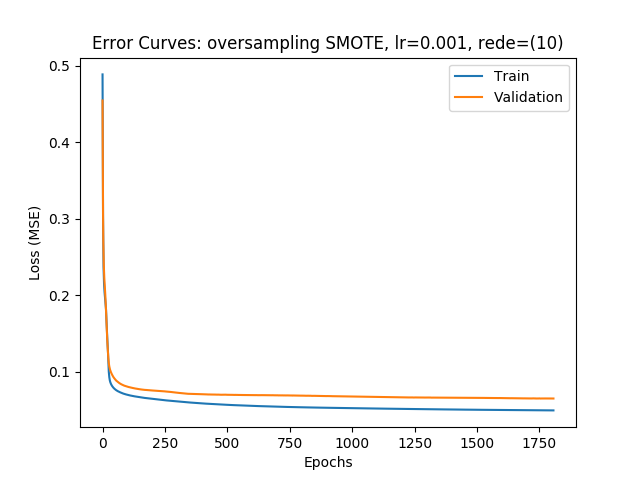

<IPython.core.display.Javascript object>


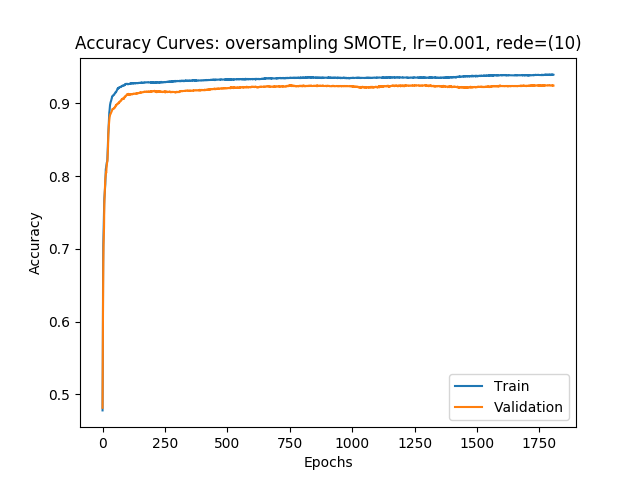

Matriz de confusão
[[1806   92]
 [   8   56]]

Train Loss:       0.0496
Validation Loss:  0.0650
Accuracy:         0.9490
MSE:              0.0510
AUROC:            0.9507


In [38]:
plot_training_error_curves(history, graficoName + "(10)")
plot_training_acc_curves(history, graficoName + "(10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (20)

In [39]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/100000
7592/7592 [==============================] - 0s - loss: 0.4921 - acc: 0.5000 - val_loss: 0.4944 - val_acc: 0.5000
Epoch 2/100000
7592/7592 [==============================] - 0s - loss: 0.4774 - acc: 0.5007 - val_loss: 0.4728 - val_acc: 0.4997
Epoch 3/100000
7592/7592 [==============================] - 0s - loss: 0.4333 - acc: 0.5177 - val_loss: 0.3933 - val_acc: 0.5229
Epoch 4/100000
7592/7592 [==============================] - 0s - loss: 0.3230 - acc: 0.5411 - val_loss: 0.2798 - val_acc: 0.5943
Epoch 5/100000
7592/7592 [==============================] - 0s - loss: 0.2394 - acc: 0.6662 - val_loss: 0.2098 - val_acc: 0.7234
Epoch 6/100000
7592/7592 [==============================] - 0s - loss: 0.1820 - acc: 0.7848 - val_loss: 0.1637 - val_acc: 0.7974
Epoch 7/100000
7592/7592 [==============================] - 0s - loss: 0.1447 - acc: 0.8329 - val_loss: 0.1419 - val_acc: 0.8422
Epoch 8/100000
7592/7592 [=======================

7592/7592 [==============================] - 0s - loss: 0.0786 - acc: 0.9215 - val_loss: 0.0975 - val_acc: 0.9102
Epoch 64/100000
7592/7592 [==============================] - 0s - loss: 0.0785 - acc: 0.9216 - val_loss: 0.0973 - val_acc: 0.9102
Epoch 65/100000
7592/7592 [==============================] - 0s - loss: 0.0784 - acc: 0.9218 - val_loss: 0.0972 - val_acc: 0.9107
Epoch 66/100000
7592/7592 [==============================] - 0s - loss: 0.0783 - acc: 0.9218 - val_loss: 0.0971 - val_acc: 0.9107
Epoch 67/100000
7592/7592 [==============================] - 0s - loss: 0.0782 - acc: 0.9219 - val_loss: 0.0970 - val_acc: 0.9107
Epoch 68/100000
7592/7592 [==============================] - 0s - loss: 0.0781 - acc: 0.9220 - val_loss: 0.0969 - val_acc: 0.9107
Epoch 69/100000
7592/7592 [==============================] - 0s - loss: 0.0780 - acc: 0.9218 - val_loss: 0.0968 - val_acc: 0.9107
Epoch 70/100000
7592/7592 [==============================] - 0s - loss: 0.0779 - acc: 0.9220 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9222 - val_loss: 0.0919 - val_acc: 0.9094
Epoch 126/100000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9220 - val_loss: 0.0918 - val_acc: 0.9094
Epoch 127/100000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9222 - val_loss: 0.0917 - val_acc: 0.9094
Epoch 128/100000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9224 - val_loss: 0.0917 - val_acc: 0.9094
Epoch 129/100000
7592/7592 [==============================] - 0s - loss: 0.0735 - acc: 0.9223 - val_loss: 0.0916 - val_acc: 0.9094
Epoch 130/100000
7592/7592 [==============================] - 0s - loss: 0.0735 - acc: 0.9224 - val_loss: 0.0916 - val_acc: 0.9094
Epoch 131/100000
7592/7592 [==============================] - 0s - loss: 0.0734 - acc: 0.9226 - val_loss: 0.0915 - val_acc: 0.9094
Epoch 132/100000
7592/7592 [==============================] - 0s - loss: 0.0733 - acc: 0.9224 - val_

7592/7592 [==============================] - 0s - loss: 0.0708 - acc: 0.9228 - val_loss: 0.0892 - val_acc: 0.9096
Epoch 188/100000
7592/7592 [==============================] - 0s - loss: 0.0707 - acc: 0.9229 - val_loss: 0.0892 - val_acc: 0.9096
Epoch 189/100000
7592/7592 [==============================] - 0s - loss: 0.0707 - acc: 0.9231 - val_loss: 0.0892 - val_acc: 0.9096
Epoch 190/100000
7592/7592 [==============================] - 0s - loss: 0.0707 - acc: 0.9229 - val_loss: 0.0891 - val_acc: 0.9096
Epoch 191/100000
7592/7592 [==============================] - 0s - loss: 0.0706 - acc: 0.9228 - val_loss: 0.0891 - val_acc: 0.9094
Epoch 192/100000
7592/7592 [==============================] - 0s - loss: 0.0706 - acc: 0.9227 - val_loss: 0.0891 - val_acc: 0.9094
Epoch 193/100000
7592/7592 [==============================] - 0s - loss: 0.0706 - acc: 0.9229 - val_loss: 0.0891 - val_acc: 0.9094
Epoch 194/100000
7592/7592 [==============================] - 0s - loss: 0.0705 - acc: 0.9227 - val_

7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9240 - val_loss: 0.0874 - val_acc: 0.9091
Epoch 250/100000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9240 - val_loss: 0.0874 - val_acc: 0.9091
Epoch 251/100000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9237 - val_loss: 0.0874 - val_acc: 0.9091
Epoch 252/100000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9237 - val_loss: 0.0873 - val_acc: 0.9094
Epoch 253/100000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9240 - val_loss: 0.0873 - val_acc: 0.9089
Epoch 254/100000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9239 - val_loss: 0.0873 - val_acc: 0.9091
Epoch 255/100000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9237 - val_loss: 0.0872 - val_acc: 0.9091
Epoch 256/100000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9239 - val_

7592/7592 [==============================] - 0s - loss: 0.0675 - acc: 0.9244 - val_loss: 0.0861 - val_acc: 0.9096
Epoch 312/100000
7592/7592 [==============================] - 0s - loss: 0.0675 - acc: 0.9245 - val_loss: 0.0860 - val_acc: 0.9096
Epoch 313/100000
7592/7592 [==============================] - 0s - loss: 0.0675 - acc: 0.9245 - val_loss: 0.0860 - val_acc: 0.9096
Epoch 314/100000
7592/7592 [==============================] - 0s - loss: 0.0675 - acc: 0.9247 - val_loss: 0.0860 - val_acc: 0.9102
Epoch 315/100000
7592/7592 [==============================] - 0s - loss: 0.0674 - acc: 0.9245 - val_loss: 0.0860 - val_acc: 0.9102
Epoch 316/100000
7592/7592 [==============================] - 0s - loss: 0.0674 - acc: 0.9245 - val_loss: 0.0859 - val_acc: 0.9099
Epoch 317/100000
7592/7592 [==============================] - 0s - loss: 0.0674 - acc: 0.9244 - val_loss: 0.0859 - val_acc: 0.9102
Epoch 318/100000
7592/7592 [==============================] - 0s - loss: 0.0674 - acc: 0.9247 - val_

7592/7592 [==============================] - 0s - loss: 0.0664 - acc: 0.9253 - val_loss: 0.0849 - val_acc: 0.9096
Epoch 374/100000
7592/7592 [==============================] - 0s - loss: 0.0664 - acc: 0.9249 - val_loss: 0.0848 - val_acc: 0.9096
Epoch 375/100000
7592/7592 [==============================] - 0s - loss: 0.0664 - acc: 0.9249 - val_loss: 0.0848 - val_acc: 0.9096
Epoch 376/100000
7592/7592 [==============================] - 0s - loss: 0.0664 - acc: 0.9253 - val_loss: 0.0848 - val_acc: 0.9096
Epoch 377/100000
7592/7592 [==============================] - 0s - loss: 0.0664 - acc: 0.9252 - val_loss: 0.0848 - val_acc: 0.9096
Epoch 378/100000
7592/7592 [==============================] - 0s - loss: 0.0663 - acc: 0.9252 - val_loss: 0.0848 - val_acc: 0.9096
Epoch 379/100000
7592/7592 [==============================] - 0s - loss: 0.0663 - acc: 0.9251 - val_loss: 0.0847 - val_acc: 0.9096
Epoch 380/100000
7592/7592 [==============================] - 0s - loss: 0.0663 - acc: 0.9254 - val_

7592/7592 [==============================] - 0s - loss: 0.0655 - acc: 0.9261 - val_loss: 0.0839 - val_acc: 0.9110
Epoch 436/100000
7592/7592 [==============================] - 0s - loss: 0.0655 - acc: 0.9258 - val_loss: 0.0839 - val_acc: 0.9110
Epoch 437/100000
7592/7592 [==============================] - 0s - loss: 0.0655 - acc: 0.9261 - val_loss: 0.0839 - val_acc: 0.9110
Epoch 438/100000
7592/7592 [==============================] - ETA: 0s - loss: 0.0654 - acc: 0.925 - 0s - loss: 0.0655 - acc: 0.9258 - val_loss: 0.0839 - val_acc: 0.9110
Epoch 439/100000
7592/7592 [==============================] - 0s - loss: 0.0655 - acc: 0.9258 - val_loss: 0.0839 - val_acc: 0.9107
Epoch 440/100000
7592/7592 [==============================] - 0s - loss: 0.0655 - acc: 0.9261 - val_loss: 0.0839 - val_acc: 0.9107
Epoch 441/100000
7592/7592 [==============================] - 0s - loss: 0.0654 - acc: 0.9258 - val_loss: 0.0838 - val_acc: 0.9107
Epoch 442/100000
7592/7592 [==============================] - 

7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9266 - val_loss: 0.0831 - val_acc: 0.9110
Epoch 498/100000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9265 - val_loss: 0.0831 - val_acc: 0.9110
Epoch 499/100000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9270 - val_loss: 0.0831 - val_acc: 0.9110
Epoch 500/100000
7592/7592 [==============================] - 0s - loss: 0.0647 - acc: 0.9268 - val_loss: 0.0830 - val_acc: 0.9110
Epoch 501/100000
7592/7592 [==============================] - 0s - loss: 0.0647 - acc: 0.9269 - val_loss: 0.0830 - val_acc: 0.9110
Epoch 502/100000
7592/7592 [==============================] - 0s - loss: 0.0647 - acc: 0.9270 - val_loss: 0.0830 - val_acc: 0.9110
Epoch 503/100000
7592/7592 [==============================] - 0s - loss: 0.0647 - acc: 0.9268 - val_loss: 0.0830 - val_acc: 0.9110
Epoch 504/100000
7592/7592 [==============================] - 0s - loss: 0.0647 - acc: 0.9268 - val_

7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9274 - val_loss: 0.0824 - val_acc: 0.9123
Epoch 560/100000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9276 - val_loss: 0.0823 - val_acc: 0.9128
Epoch 561/100000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9276 - val_loss: 0.0823 - val_acc: 0.9123
Epoch 562/100000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9273 - val_loss: 0.0823 - val_acc: 0.9128
Epoch 563/100000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9273 - val_loss: 0.0823 - val_acc: 0.9125
Epoch 564/100000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9274 - val_loss: 0.0823 - val_acc: 0.9123
Epoch 565/100000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9274 - val_loss: 0.0823 - val_acc: 0.9125
Epoch 566/100000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9276 - val_

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9280 - val_loss: 0.0816 - val_acc: 0.9128
Epoch 622/100000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9278 - val_loss: 0.0816 - val_acc: 0.9131
Epoch 623/100000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9277 - val_loss: 0.0816 - val_acc: 0.9131
Epoch 624/100000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9278 - val_loss: 0.0816 - val_acc: 0.9128
Epoch 625/100000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9277 - val_loss: 0.0815 - val_acc: 0.9131
Epoch 626/100000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9277 - val_loss: 0.0815 - val_acc: 0.9128
Epoch 627/100000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9280 - val_loss: 0.0815 - val_acc: 0.9131
Epoch 628/100000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9280 - val_

7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9280 - val_loss: 0.0810 - val_acc: 0.9139
Epoch 684/100000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9282 - val_loss: 0.0810 - val_acc: 0.9133
Epoch 685/100000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9282 - val_loss: 0.0809 - val_acc: 0.9136
Epoch 686/100000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9282 - val_loss: 0.0809 - val_acc: 0.9136
Epoch 687/100000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9281 - val_loss: 0.0809 - val_acc: 0.9136
Epoch 688/100000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9283 - val_loss: 0.0809 - val_acc: 0.9131
Epoch 689/100000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9282 - val_loss: 0.0809 - val_acc: 0.9133
Epoch 690/100000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9282 - val_

7592/7592 [==============================] - 0s - loss: 0.0624 - acc: 0.9289 - val_loss: 0.0804 - val_acc: 0.9133
Epoch 746/100000
7592/7592 [==============================] - 0s - loss: 0.0624 - acc: 0.9289 - val_loss: 0.0804 - val_acc: 0.9133
Epoch 747/100000
7592/7592 [==============================] - 0s - loss: 0.0624 - acc: 0.9290 - val_loss: 0.0804 - val_acc: 0.9136
Epoch 748/100000
7592/7592 [==============================] - ETA: 0s - loss: 0.0618 - acc: 0.930 - 0s - loss: 0.0624 - acc: 0.9293 - val_loss: 0.0804 - val_acc: 0.9133
Epoch 749/100000
7592/7592 [==============================] - 0s - loss: 0.0624 - acc: 0.9290 - val_loss: 0.0804 - val_acc: 0.9139
Epoch 750/100000
7592/7592 [==============================] - 0s - loss: 0.0624 - acc: 0.9291 - val_loss: 0.0804 - val_acc: 0.9139
Epoch 751/100000
7592/7592 [==============================] - 0s - loss: 0.0624 - acc: 0.9290 - val_loss: 0.0804 - val_acc: 0.9139
Epoch 752/100000
7592/7592 [==============================] - 

7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9290 - val_loss: 0.0800 - val_acc: 0.9141
Epoch 808/100000
7592/7592 [==============================] - ETA: 0s - loss: 0.0615 - acc: 0.929 - 0s - loss: 0.0619 - acc: 0.9291 - val_loss: 0.0800 - val_acc: 0.9144
Epoch 809/100000
7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9291 - val_loss: 0.0799 - val_acc: 0.9146
Epoch 810/100000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9291 - val_loss: 0.0799 - val_acc: 0.9146
Epoch 811/100000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9289 - val_loss: 0.0799 - val_acc: 0.9144
Epoch 812/100000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9290 - val_loss: 0.0799 - val_acc: 0.9146
Epoch 813/100000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9287 - val_loss: 0.0799 - val_acc: 0.9141
Epoch 814/100000
7592/7592 [==============================] - 

7592/7592 [==============================] - 0s - loss: 0.0614 - acc: 0.9297 - val_loss: 0.0795 - val_acc: 0.9146
Epoch 870/100000
7592/7592 [==============================] - 0s - loss: 0.0614 - acc: 0.9295 - val_loss: 0.0795 - val_acc: 0.9146
Epoch 871/100000
7592/7592 [==============================] - 0s - loss: 0.0614 - acc: 0.9295 - val_loss: 0.0795 - val_acc: 0.9146
Epoch 872/100000
7592/7592 [==============================] - 0s - loss: 0.0614 - acc: 0.9295 - val_loss: 0.0795 - val_acc: 0.9146
Epoch 873/100000
7592/7592 [==============================] - 0s - loss: 0.0614 - acc: 0.9297 - val_loss: 0.0795 - val_acc: 0.9146
Epoch 874/100000
7592/7592 [==============================] - 0s - loss: 0.0614 - acc: 0.9295 - val_loss: 0.0795 - val_acc: 0.9146
Epoch 875/100000
7592/7592 [==============================] - 0s - loss: 0.0614 - acc: 0.9297 - val_loss: 0.0794 - val_acc: 0.9146
Epoch 876/100000
7592/7592 [==============================] - 0s - loss: 0.0614 - acc: 0.9295 - val_

7592/7592 [==============================] - 0s - loss: 0.0610 - acc: 0.9298 - val_loss: 0.0792 - val_acc: 0.9154
Epoch 932/100000
7592/7592 [==============================] - 0s - loss: 0.0610 - acc: 0.9298 - val_loss: 0.0792 - val_acc: 0.9154
Epoch 933/100000
7592/7592 [==============================] - 0s - loss: 0.0610 - acc: 0.9298 - val_loss: 0.0792 - val_acc: 0.9154
Epoch 934/100000
7592/7592 [==============================] - 0s - loss: 0.0610 - acc: 0.9297 - val_loss: 0.0792 - val_acc: 0.9154
Epoch 935/100000
7592/7592 [==============================] - 0s - loss: 0.0610 - acc: 0.9298 - val_loss: 0.0792 - val_acc: 0.9152
Epoch 936/100000
7592/7592 [==============================] - 0s - loss: 0.0610 - acc: 0.9298 - val_loss: 0.0792 - val_acc: 0.9154
Epoch 937/100000
7592/7592 [==============================] - 0s - loss: 0.0609 - acc: 0.9299 - val_loss: 0.0792 - val_acc: 0.9149
Epoch 938/100000
7592/7592 [==============================] - 0s - loss: 0.0609 - acc: 0.9298 - val_

7592/7592 [==============================] - 0s - loss: 0.0606 - acc: 0.9302 - val_loss: 0.0790 - val_acc: 0.9154
Epoch 994/100000
7592/7592 [==============================] - 0s - loss: 0.0606 - acc: 0.9302 - val_loss: 0.0790 - val_acc: 0.9154
Epoch 995/100000
7592/7592 [==============================] - 0s - loss: 0.0606 - acc: 0.9303 - val_loss: 0.0790 - val_acc: 0.9154
Epoch 996/100000
7592/7592 [==============================] - 0s - loss: 0.0606 - acc: 0.9302 - val_loss: 0.0790 - val_acc: 0.9152
Epoch 997/100000
7592/7592 [==============================] - 0s - loss: 0.0606 - acc: 0.9299 - val_loss: 0.0790 - val_acc: 0.9152
Epoch 998/100000
7592/7592 [==============================] - 0s - loss: 0.0606 - acc: 0.9302 - val_loss: 0.0790 - val_acc: 0.9154
Epoch 999/100000
7592/7592 [==============================] - 0s - loss: 0.0606 - acc: 0.9303 - val_loss: 0.0790 - val_acc: 0.9152
Epoch 1000/100000
7592/7592 [==============================] - 0s - loss: 0.0606 - acc: 0.9301 - val

7592/7592 [==============================] - 0s - loss: 0.0603 - acc: 0.9310 - val_loss: 0.0789 - val_acc: 0.9149
Epoch 1056/100000
7592/7592 [==============================] - 0s - loss: 0.0603 - acc: 0.9308 - val_loss: 0.0789 - val_acc: 0.9149
Epoch 1057/100000
7592/7592 [==============================] - 0s - loss: 0.0602 - acc: 0.9311 - val_loss: 0.0788 - val_acc: 0.9149
Epoch 1058/100000
7592/7592 [==============================] - 0s - loss: 0.0602 - acc: 0.9314 - val_loss: 0.0788 - val_acc: 0.9146
Epoch 1059/100000
7592/7592 [==============================] - 0s - loss: 0.0602 - acc: 0.9312 - val_loss: 0.0788 - val_acc: 0.9149
Epoch 1060/100000
7592/7592 [==============================] - 0s - loss: 0.0602 - acc: 0.9312 - val_loss: 0.0788 - val_acc: 0.9149
Epoch 1061/100000
7592/7592 [==============================] - 0s - loss: 0.0602 - acc: 0.9312 - val_loss: 0.0788 - val_acc: 0.9149
Epoch 1062/100000
7592/7592 [==============================] - 0s - loss: 0.0602 - acc: 0.9312

7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9323 - val_loss: 0.0787 - val_acc: 0.9152
Epoch 1118/100000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9322 - val_loss: 0.0787 - val_acc: 0.9149
Epoch 1119/100000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9323 - val_loss: 0.0787 - val_acc: 0.9149
Epoch 1120/100000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9320 - val_loss: 0.0787 - val_acc: 0.9149
Epoch 1121/100000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9319 - val_loss: 0.0787 - val_acc: 0.9149
Epoch 1122/100000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9319 - val_loss: 0.0787 - val_acc: 0.9152
Epoch 1123/100000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9322 - val_loss: 0.0787 - val_acc: 0.9152
Epoch 1124/100000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9322

7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9322 - val_loss: 0.0787 - val_acc: 0.9149
Epoch 1180/100000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9322 - val_loss: 0.0787 - val_acc: 0.9152
Epoch 1181/100000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9322 - val_loss: 0.0787 - val_acc: 0.9149
Epoch 1182/100000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9322 - val_loss: 0.0787 - val_acc: 0.9146
Epoch 1183/100000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9320 - val_loss: 0.0787 - val_acc: 0.9146
Epoch 1184/100000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9318 - val_loss: 0.0787 - val_acc: 0.9146
Epoch 1185/100000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9320 - val_loss: 0.0787 - val_acc: 0.9146
Epoch 1186/100000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9322

In [40]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1376/1962 [====================>.........] - ETA: 0s[0.038229637688394186, 0.94903160040774714]


<IPython.core.display.Javascript object>


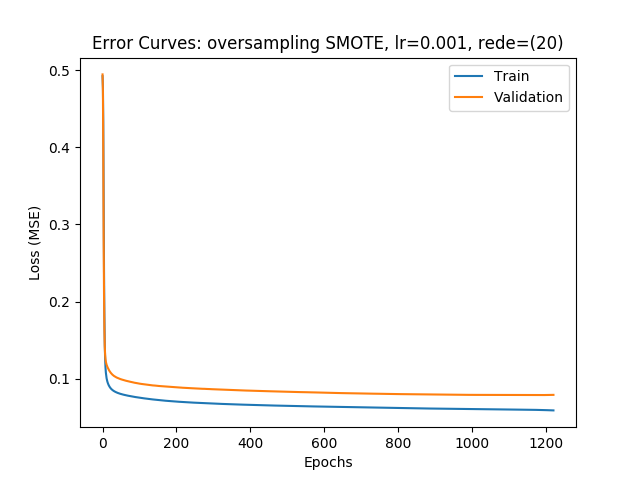

<IPython.core.display.Javascript object>


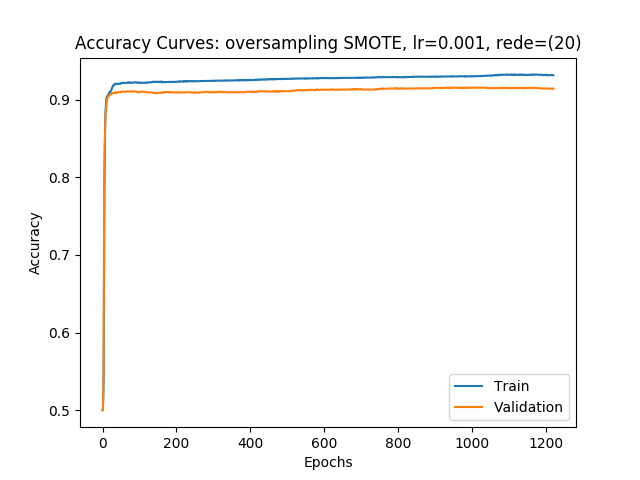

Matriz de confusão
[[1805   93]
 [   7   57]]

Train Loss:       0.0596
Validation Loss:  0.0787
Accuracy:         0.9490
MSE:              0.0510
AUROC:            0.9435


In [41]:
plot_training_error_curves(history, graficoName + "(20)")
plot_training_acc_curves(history, graficoName + "(20)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (10, 15)

In [27]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(15, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/100000
7592/7592 [==============================] - 0s - loss: 0.1868 - acc: 0.7653 - val_loss: 0.1253 - val_acc: 0.8527
Epoch 2/100000
7592/7592 [==============================] - 0s - loss: 0.1134 - acc: 0.8639 - val_loss: 0.1069 - val_acc: 0.8846
Epoch 3/100000
7592/7592 [==============================] - 0s - loss: 0.1004 - acc: 0.8822 - val_loss: 0.0960 - val_acc: 0.8991
Epoch 4/100000
7592/7592 [==============================] - 0s - loss: 0.0910 - acc: 0.8938 - val_loss: 0.0898 - val_acc: 0.9075
Epoch 5/100000
7592/7592 [==============================] - 0s - loss: 0.0844 - acc: 0.9021 - val_loss: 0.0862 - val_acc: 0.8981
Epoch 6/100000
7592/7592 [==============================] - 0s - loss: 0.0790 - acc: 0.9058 - val_loss: 0.0861 - val_acc: 0.8975
Epoch 7/100000
7592/7592 [==============================] - 0s - loss: 0.0749 - acc: 0.9110 - val_loss: 0.0823 - val_acc: 0.9023
Epoch 8/100000
7592/7592 [=======================

7592/7592 [==============================] - 0s - loss: 0.0499 - acc: 0.9451 - val_loss: 0.0685 - val_acc: 0.9247
Epoch 64/100000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9460 - val_loss: 0.0690 - val_acc: 0.9241
Epoch 65/100000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9453 - val_loss: 0.0686 - val_acc: 0.9236
Epoch 66/100000
7592/7592 [==============================] - 0s - loss: 0.0494 - acc: 0.9452 - val_loss: 0.0695 - val_acc: 0.9236
Epoch 67/100000
7592/7592 [==============================] - 0s - loss: 0.0492 - acc: 0.9457 - val_loss: 0.0688 - val_acc: 0.9223
Epoch 68/100000
7592/7592 [==============================] - 0s - loss: 0.0492 - acc: 0.9469 - val_loss: 0.0689 - val_acc: 0.9239
Epoch 69/100000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9465 - val_loss: 0.0679 - val_acc: 0.9252
Epoch 70/100000
7592/7592 [==============================] - 0s - loss: 0.0487 - acc: 0.9468 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0431 - acc: 0.9530 - val_loss: 0.0666 - val_acc: 0.9233
Epoch 126/100000
7592/7592 [==============================] - 0s - loss: 0.0430 - acc: 0.9526 - val_loss: 0.0660 - val_acc: 0.9215
Epoch 127/100000
7592/7592 [==============================] - 0s - loss: 0.0430 - acc: 0.9535 - val_loss: 0.0663 - val_acc: 0.9228
Epoch 128/100000
7592/7592 [==============================] - 0s - loss: 0.0428 - acc: 0.9534 - val_loss: 0.0668 - val_acc: 0.9212
Epoch 129/100000
7592/7592 [==============================] - 0s - loss: 0.0427 - acc: 0.9532 - val_loss: 0.0662 - val_acc: 0.9199
Epoch 130/100000
7592/7592 [==============================] - 0s - loss: 0.0426 - acc: 0.9531 - val_loss: 0.0665 - val_acc: 0.9244
Epoch 131/100000
7592/7592 [==============================] - 0s - loss: 0.0426 - acc: 0.9542 - val_loss: 0.0670 - val_acc: 0.9212
Epoch 132/100000
7592/7592 [==============================] - 0s - loss: 0.0426 - acc: 0.9543 - val_

7592/7592 [==============================] - 0s - loss: 0.0393 - acc: 0.9575 - val_loss: 0.0664 - val_acc: 0.9220
Epoch 188/100000
7592/7592 [==============================] - 0s - loss: 0.0393 - acc: 0.9571 - val_loss: 0.0661 - val_acc: 0.9286
Epoch 189/100000
7592/7592 [==============================] - 0s - loss: 0.0394 - acc: 0.9573 - val_loss: 0.0651 - val_acc: 0.9247
Epoch 190/100000
7592/7592 [==============================] - 0s - loss: 0.0393 - acc: 0.9565 - val_loss: 0.0656 - val_acc: 0.9252
Epoch 191/100000
7592/7592 [==============================] - 0s - loss: 0.0392 - acc: 0.9572 - val_loss: 0.0662 - val_acc: 0.9223
Epoch 192/100000
7592/7592 [==============================] - 0s - loss: 0.0391 - acc: 0.9567 - val_loss: 0.0673 - val_acc: 0.9228
Epoch 193/100000
7592/7592 [==============================] - 0s - loss: 0.0393 - acc: 0.9565 - val_loss: 0.0654 - val_acc: 0.9291
Epoch 194/100000
7592/7592 [==============================] - 0s - loss: 0.0391 - acc: 0.9573 - val_

7592/7592 [==============================] - 0s - loss: 0.0371 - acc: 0.9597 - val_loss: 0.0631 - val_acc: 0.9257
Epoch 250/100000
7592/7592 [==============================] - 0s - loss: 0.0370 - acc: 0.9601 - val_loss: 0.0628 - val_acc: 0.9291
Epoch 251/100000
7592/7592 [==============================] - 0s - loss: 0.0371 - acc: 0.9600 - val_loss: 0.0623 - val_acc: 0.9291
Epoch 252/100000
7592/7592 [==============================] - 0s - loss: 0.0371 - acc: 0.9590 - val_loss: 0.0648 - val_acc: 0.9220
Epoch 253/100000
7592/7592 [==============================] - 0s - loss: 0.0370 - acc: 0.9610 - val_loss: 0.0627 - val_acc: 0.9268
Epoch 254/100000
7592/7592 [==============================] - 0s - loss: 0.0369 - acc: 0.9600 - val_loss: 0.0636 - val_acc: 0.9294
Epoch 255/100000
7592/7592 [==============================] - 0s - loss: 0.0370 - acc: 0.9598 - val_loss: 0.0635 - val_acc: 0.9247
Epoch 256/100000
7592/7592 [==============================] - 0s - loss: 0.0369 - acc: 0.9593 - val_

7592/7592 [==============================] - 0s - loss: 0.0360 - acc: 0.9606 - val_loss: 0.0638 - val_acc: 0.9212
Epoch 312/100000
7592/7592 [==============================] - 0s - loss: 0.0359 - acc: 0.9607 - val_loss: 0.0619 - val_acc: 0.9276
Epoch 313/100000
7592/7592 [==============================] - 0s - loss: 0.0358 - acc: 0.9607 - val_loss: 0.0630 - val_acc: 0.9241
Epoch 314/100000
7592/7592 [==============================] - 0s - loss: 0.0358 - acc: 0.9618 - val_loss: 0.0649 - val_acc: 0.9194
Epoch 315/100000
7592/7592 [==============================] - 0s - loss: 0.0360 - acc: 0.9605 - val_loss: 0.0620 - val_acc: 0.9281
Epoch 316/100000
7592/7592 [==============================] - 0s - loss: 0.0358 - acc: 0.9611 - val_loss: 0.0620 - val_acc: 0.9260
Epoch 317/100000
7592/7592 [==============================] - 0s - loss: 0.0357 - acc: 0.9611 - val_loss: 0.0618 - val_acc: 0.9273
Epoch 318/100000
7592/7592 [==============================] - 0s - loss: 0.0356 - acc: 0.9611 - val_

In [28]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1952/1962 [============================>.] - ETA: 0s[0.035091736020708302, 0.95361875637104998]


<IPython.core.display.Javascript object>


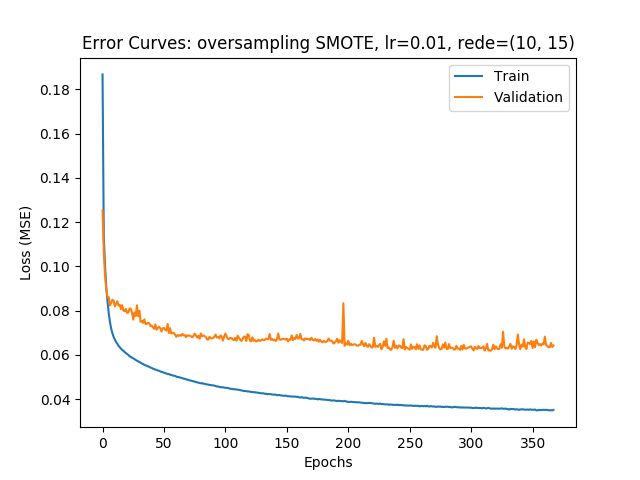

<IPython.core.display.Javascript object>


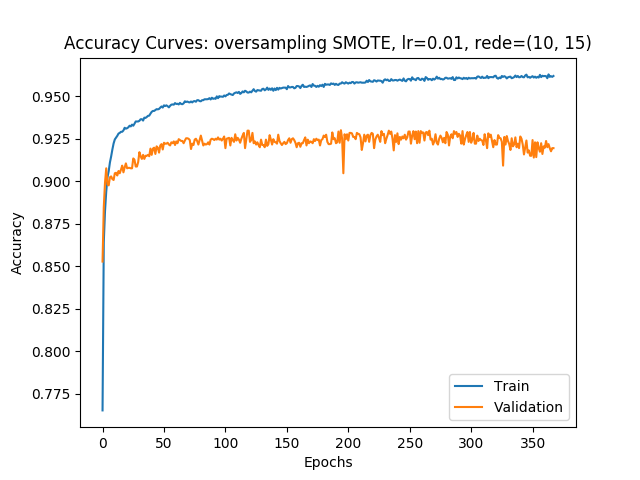

Matriz de confusão
[[1816   82]
 [   8   56]]

Train Loss:       0.0357
Validation Loss:  0.0618
Accuracy:         0.9541
MSE:              0.0459
AUROC:            0.9405


In [29]:
plot_training_error_curves(history, graficoName + "(10, 15)")
plot_training_acc_curves(history,graficoName + "(10, 15)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (20, 10)

In [31]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(10, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu'))

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/100000
7592/7592 [==============================] - 0s - loss: 0.1525 - acc: 0.7914 - val_loss: 0.1268 - val_acc: 0.8667
Epoch 2/100000
7592/7592 [==============================] - 0s - loss: 0.0999 - acc: 0.8930 - val_loss: 0.1109 - val_acc: 0.8865
Epoch 3/100000
7592/7592 [==============================] - 0s - loss: 0.0897 - acc: 0.9115 - val_loss: 0.1010 - val_acc: 0.8959
Epoch 4/100000
7592/7592 [==============================] - 0s - loss: 0.0843 - acc: 0.9193 - val_loss: 0.0954 - val_acc: 0.8996
Epoch 5/100000
7592/7592 [==============================] - 0s - loss: 0.0805 - acc: 0.9228 - val_loss: 0.0928 - val_acc: 0.8999
Epoch 6/100000
7592/7592 [==============================] - 0s - loss: 0.0777 - acc: 0.9247 - val_loss: 0.0898 - val_acc: 0.9041
Epoch 7/100000
7592/7592 [==============================] - 0s - loss: 0.0756 - acc: 0.9236 - val_loss: 0.0902 - val_acc: 0.9046
Epoch 8/100000
7592/7592 [=======================

7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9518 - val_loss: 0.0669 - val_acc: 0.9183
Epoch 64/100000
7592/7592 [==============================] - 0s - loss: 0.0415 - acc: 0.9513 - val_loss: 0.0668 - val_acc: 0.9183
Epoch 65/100000
7592/7592 [==============================] - 0s - loss: 0.0412 - acc: 0.9515 - val_loss: 0.0665 - val_acc: 0.9189
Epoch 66/100000
7592/7592 [==============================] - 0s - loss: 0.0409 - acc: 0.9513 - val_loss: 0.0675 - val_acc: 0.9144
Epoch 67/100000
7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9528 - val_loss: 0.0666 - val_acc: 0.9160
Epoch 68/100000
7592/7592 [==============================] - 0s - loss: 0.0405 - acc: 0.9527 - val_loss: 0.0667 - val_acc: 0.9165
Epoch 69/100000
7592/7592 [==============================] - 0s - loss: 0.0403 - acc: 0.9538 - val_loss: 0.0667 - val_acc: 0.9165
Epoch 70/100000
7592/7592 [==============================] - 0s - loss: 0.0401 - acc: 0.9530 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0329 - acc: 0.9614 - val_loss: 0.0632 - val_acc: 0.9191
Epoch 126/100000
7592/7592 [==============================] - 0s - loss: 0.0328 - acc: 0.9611 - val_loss: 0.0630 - val_acc: 0.9189
Epoch 127/100000
7592/7592 [==============================] - 0s - loss: 0.0327 - acc: 0.9610 - val_loss: 0.0626 - val_acc: 0.9199
Epoch 128/100000
7592/7592 [==============================] - 0s - loss: 0.0326 - acc: 0.9618 - val_loss: 0.0652 - val_acc: 0.9183
Epoch 129/100000
7592/7592 [==============================] - 0s - loss: 0.0326 - acc: 0.9615 - val_loss: 0.0635 - val_acc: 0.9186
Epoch 130/100000
7592/7592 [==============================] - 0s - loss: 0.0324 - acc: 0.9610 - val_loss: 0.0629 - val_acc: 0.9210
Epoch 131/100000
7592/7592 [==============================] - 0s - loss: 0.0324 - acc: 0.9622 - val_loss: 0.0651 - val_acc: 0.9152
Epoch 132/100000
7592/7592 [==============================] - 0s - loss: 0.0323 - acc: 0.9619 - val_

7592/7592 [==============================] - 0s - loss: 0.0290 - acc: 0.9679 - val_loss: 0.0672 - val_acc: 0.9107
Epoch 188/100000
7592/7592 [==============================] - 0s - loss: 0.0290 - acc: 0.9675 - val_loss: 0.0675 - val_acc: 0.9136
Epoch 189/100000
7592/7592 [==============================] - 0s - loss: 0.0289 - acc: 0.9671 - val_loss: 0.0661 - val_acc: 0.9115
Epoch 190/100000
7592/7592 [==============================] - 0s - loss: 0.0289 - acc: 0.9672 - val_loss: 0.0641 - val_acc: 0.9154


In [32]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1472/1962 [=====================>........] - ETA: 0s[0.038588575368498385, 0.95056065239551479]


<IPython.core.display.Javascript object>


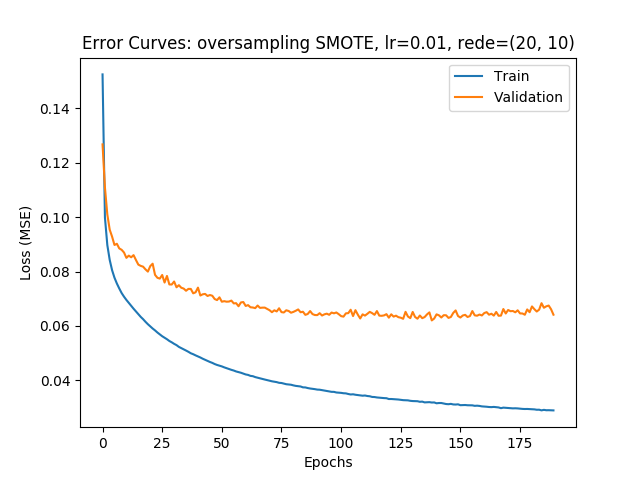

<IPython.core.display.Javascript object>


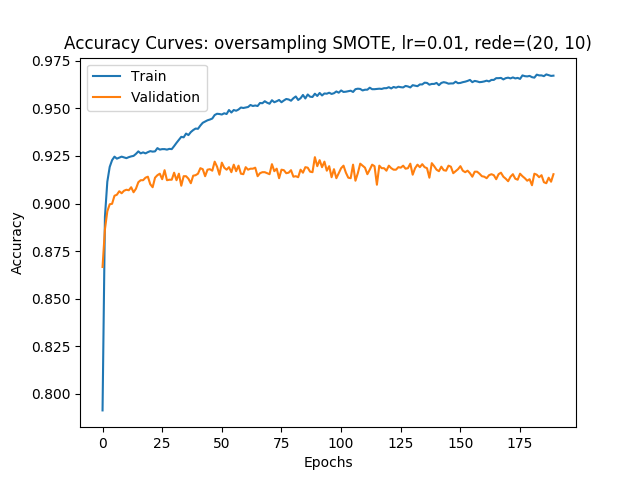

Matriz de confusão
[[1808   90]
 [   7   57]]

Train Loss:       0.0318
Validation Loss:  0.0620
Accuracy:         0.9506
MSE:              0.0494
AUROC:            0.9554


In [33]:
plot_training_error_curves(history, graficoName + "(20, 10)")
plot_training_acc_curves(history, graficoName + "(20, 10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [30]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.1776 - acc: 0.8301 - val_loss: 0.1240 - val_acc: 0.8841
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.0898 - acc: 0.9063 - val_loss: 0.1185 - val_acc: 0.8867
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.0882 - acc: 0.9057 - val_loss: 0.1118 - val_acc: 0.8878
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.0882 - acc: 0.9054 - val_loss: 0.1183 - val_acc: 0.8867
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.0878 - acc: 0.9038 - val_loss: 0.1121 - val_acc: 0.8909
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.0876 - acc: 0.9054 - val_loss: 0.1099 - val_acc: 0.8894
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.0879 - acc: 0.9040 - val_loss: 0.1097 - val_acc: 0.8904
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9037 - val_loss: 0.1131 - val_acc: 0.8886
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9038 - val_loss: 0.1085 - val_acc: 0.8901
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9054 - val_loss: 0.1175 - val_acc: 0.8801
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9053 - val_loss: 0.1240 - val_acc: 0.8754
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0864 - acc: 0.9056 - val_loss: 0.1107 - val_acc: 0.8917
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9053 - val_loss: 0.1118 - val_acc: 0.8878
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9060 - val_loss: 0.1076 - val_acc: 0.8915
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9042 - val_loss: 0.1139 -

7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9058 - val_loss: 0.1070 - val_acc: 0.8925
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9040 - val_loss: 0.1108 - val_acc: 0.8841
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9063 - val_loss: 0.1220 - val_acc: 0.8783
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0877 - acc: 0.9038 - val_loss: 0.1109 - val_acc: 0.8870
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9065 - val_loss: 0.1197 - val_acc: 0.8820
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9062 - val_loss: 0.1160 - val_acc: 0.8807
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9049 - val_loss: 0.1119 - val_acc: 0.8867
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9033 - val_loss: 0.1123 -

7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9031 - val_loss: 0.1102 - val_acc: 0.8899
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9045 - val_loss: 0.1107 - val_acc: 0.8870
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9033 - val_loss: 0.1106 - val_acc: 0.8894
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9042 - val_loss: 0.1115 - val_acc: 0.8888
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9044 - val_loss: 0.1135 - val_acc: 0.8854
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9023 - val_loss: 0.1148 - val_acc: 0.8822
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9040 - val_loss: 0.1049 - val_acc: 0.8925
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9066 - val_loss: 0.1103 -

7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9056 - val_loss: 0.1033 - val_acc: 0.8888
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9032 - val_loss: 0.1089 - val_acc: 0.8875
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9024 - val_loss: 0.1182 - val_acc: 0.8862
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0877 - acc: 0.9056 - val_loss: 0.1090 - val_acc: 0.8912
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0879 - acc: 0.9042 - val_loss: 0.1087 - val_acc: 0.8915
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9041 - val_loss: 0.1051 - val_acc: 0.8907
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9044 - val_loss: 0.1092 - val_acc: 0.8904
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9032 - val_loss: 0.1091 -

7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9032 - val_loss: 0.1189 - val_acc: 0.8791
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9057 - val_loss: 0.1062 - val_acc: 0.8915
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9044 - val_loss: 0.1202 - val_acc: 0.8775
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9025 - val_loss: 0.1128 - val_acc: 0.8846
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9057 - val_loss: 0.1206 - val_acc: 0.8751
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9040 - val_loss: 0.1209 - val_acc: 0.8772
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9044 - val_loss: 0.1085 - val_acc: 0.8894
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9042 - val_loss: 0.1072 -

7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9040 - val_loss: 0.1047 - val_acc: 0.8917
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9044 - val_loss: 0.1169 - val_acc: 0.8780
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9046 - val_loss: 0.1076 - val_acc: 0.8909
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9062 - val_loss: 0.1109 - val_acc: 0.8904
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9029 - val_loss: 0.1137 - val_acc: 0.8891
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9041 - val_loss: 0.1121 - val_acc: 0.8846
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9041 - val_loss: 0.1136 - val_acc: 0.8891
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9025 - val_loss: 0.1128 -

7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9038 - val_loss: 0.1128 - val_acc: 0.8830
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9052 - val_loss: 0.1071 - val_acc: 0.8907
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9027 - val_loss: 0.1063 - val_acc: 0.8907
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9033 - val_loss: 0.1118 - val_acc: 0.8901
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9037 - val_loss: 0.1133 - val_acc: 0.8928
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9036 - val_loss: 0.1209 - val_acc: 0.8778
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9025 - val_loss: 0.1181 - val_acc: 0.8849
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9053 - val_loss: 0.1136 -

7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9037 - val_loss: 0.1052 - val_acc: 0.8891
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9044 - val_loss: 0.1279 - val_acc: 0.8704
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9037 - val_loss: 0.1174 - val_acc: 0.8825
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9061 - val_loss: 0.1054 - val_acc: 0.8894
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9052 - val_loss: 0.1206 - val_acc: 0.8830
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9042 - val_loss: 0.1115 - val_acc: 0.8867
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9038 - val_loss: 0.1266 - val_acc: 0.8678
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0878 - acc: 0.9054 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1068 - val_acc: 0.8907
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8870
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9052 - val_loss: 0.1136 - val_acc: 0.8844
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9061 - val_loss: 0.1092 - val_acc: 0.8844
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9053 - val_loss: 0.1229 - val_acc: 0.8791
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9032 - val_loss: 0.1130 - val_acc: 0.8875
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9054 - val_loss: 0.1174 - val_acc: 0.8809
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9027 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9044 - val_loss: 0.1142 - val_acc: 0.8883
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9063 - val_loss: 0.1157 - val_acc: 0.8844
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9020 - val_loss: 0.1151 - val_acc: 0.8854
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9050 - val_loss: 0.1141 - val_acc: 0.8849
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9045 - val_loss: 0.1193 - val_acc: 0.8762
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9027 - val_loss: 0.1085 - val_acc: 0.8915
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9057 - val_loss: 0.1177 - val_acc: 0.8796
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9061 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9045 - val_loss: 0.1175 - val_acc: 0.8846
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9048 - val_loss: 0.1048 - val_acc: 0.8917
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9060 - val_loss: 0.1114 - val_acc: 0.8891
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9044 - val_loss: 0.1160 - val_acc: 0.8822
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9036 - val_loss: 0.1165 - val_acc: 0.8825
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9048 - val_loss: 0.1128 - val_acc: 0.8894
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9015 - val_loss: 0.1183 - val_acc: 0.8809
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9053 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9031 - val_loss: 0.1093 - val_acc: 0.8923
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9019 - val_loss: 0.1179 - val_acc: 0.8815
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9058 - val_loss: 0.1090 - val_acc: 0.8862
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9058 - val_loss: 0.1113 - val_acc: 0.8870
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9069 - val_loss: 0.1081 - val_acc: 0.8891
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9044 - val_loss: 0.1176 - val_acc: 0.8854
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9049 - val_loss: 0.1071 - val_acc: 0.8888
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9044 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9062 - val_loss: 0.1183 - val_acc: 0.8825
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9054 - val_loss: 0.1093 - val_acc: 0.8883
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9053 - val_loss: 0.1114 - val_acc: 0.8925
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8899
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9041 - val_loss: 0.1110 - val_acc: 0.8923
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9048 - val_loss: 0.1082 - val_acc: 0.8907
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9040 - val_loss: 0.1118 - val_acc: 0.8838
Epoch 1646/2000
7592/7592 [==============================] - 0s - loss: 0.0865 - acc: 0.9063 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9031 - val_loss: 0.1095 - val_acc: 0.8909
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9067 - val_loss: 0.1097 - val_acc: 0.8904
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0864 - acc: 0.9042 - val_loss: 0.1118 - val_acc: 0.8862
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9037 - val_loss: 0.1140 - val_acc: 0.8833
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8854
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9048 - val_loss: 0.1069 - val_acc: 0.8886
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0878 - acc: 0.9035 - val_loss: 0.1109 - val_acc: 0.8888
Epoch 1772/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9032 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9037 - val_loss: 0.1083 - val_acc: 0.8917
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0876 - acc: 0.9032 - val_loss: 0.1061 - val_acc: 0.8896
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9038 - val_loss: 0.1164 - val_acc: 0.8859
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9042 - val_loss: 0.1103 - val_acc: 0.8896
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9046 - val_loss: 0.1107 - val_acc: 0.8862
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9046 - val_loss: 0.1109 - val_acc: 0.8838
Epoch 1897/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9058 - val_loss: 0.1189 - val_acc: 0.8809
Epoch 1898/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9031 - val_loss: 0

In [31]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1962/1962 [==============================] - 0s     
[0.062036256872641568, 0.9327217125989854]


<IPython.core.display.Javascript object>


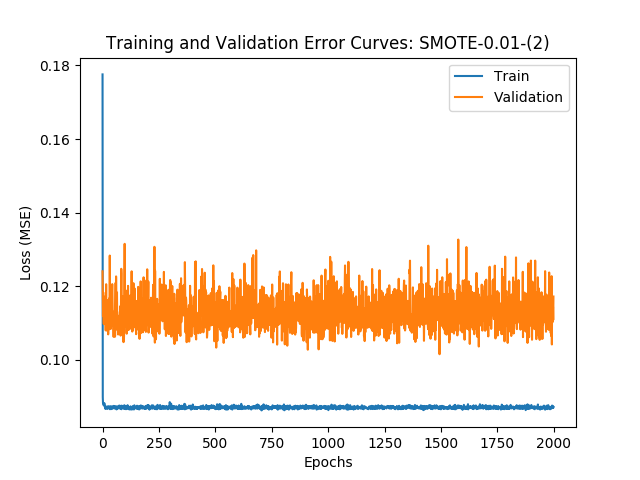

<IPython.core.display.Javascript object>


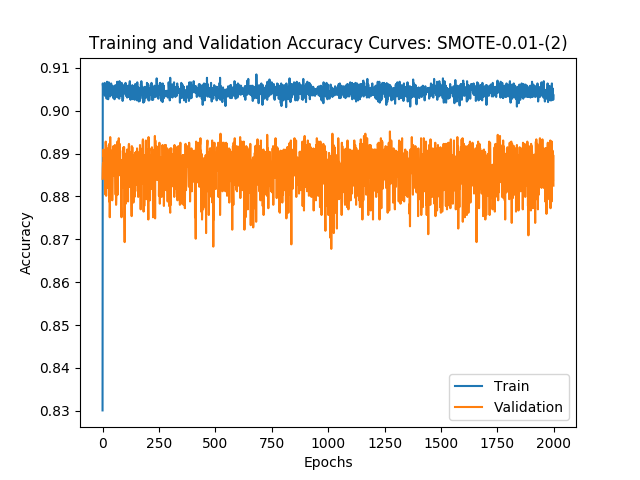

Matriz de confusão
[[1778  120]
 [   9   55]]

Train Loss:       0.0869
Validation Loss:  0.1015
Accuracy:         0.9343
MSE:              0.0657
AUROC:            0.9496


In [32]:
plot_training_error_curves(history, graficoName + "(2)")
plot_training_acc_curves(history, graficoName + "(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [ ]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history, graficoName + "(4)")
plot_training_acc_curves(history, graficoName + "(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))